# PINNs (Physics Informed Neural Networks)
---

This is an implentation of a physics informed neural network, to solve the logistic equation in pytorch, a PINN works by defining a function $f$ which is a neural network, and a loss function such that when the loss function is minimized $f$ is approximetly equal to the solution of the differential equation 

##Required libraries
- pytorch
- numpy
- scipy (ODE Solver for comparision)
- matplotlib (Drawing graphs)



In [11]:
# import libraries
from torch import nn as nn
import torch
import torch.autograd as ag
import numpy as np
import matplotlib.pyplot as plt



#Defining the diffrential equation
---

For this implementation I have decide to solve the logistic equation which is given by the following equation $\frac{df}{dt} = rt(1-t)$ this servers mostly as an example problem to learn about PINN and how they work, the analytic solution to the problem can found as follows:
$$
    \frac{df}{dt} = rt(1-t) \\
    df = (rt - rt^2)dt \\
    \int{df} = \int{(rt - rt^2)dt} \\
    f(t) = \int{rtdt} - \int{rt^2dt} \\
    f(t) = -\frac{r}{3}t^3 + \frac{r}{2}t^2 + c
$$

- with $r = 1$ and $f(0) = 1$  

The analytic solution will be used to compare the output of the model

In [7]:
def differential_equation(t: torch.Tensor) -> torch.Tensor:
    R: float = 1.0
    return R*t*(1-t)

def analytic_solution(x):
    return (-1/3)*(x**3) + 0.5*(x**2) + 1     

#Defining the neural Network architecture
---

The neural network consists of a simple fully connected layer with 1 input and 1 output since this an ODE (Odinary differential equation) this neural network plays the role of function $f$ as mentioned above


In [4]:
class ApproximatorNet(nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 1, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        """
            Builds an neural network to approximate the value of the differential equation
            input_size must be set to number of parameters in the function f for ODE this is 1
            output_size number of values output by the function for ODE this is 1
        """
        super().__init__()
        
        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size) 
        
        self.activation = nn.Tanh() # Can be either tanh or sigmoid, ReLU is not differentiable (at 0)
    
    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
        """
            Runs the input through the hidden layers
        """
        for layer in self.model:
            x = self.activation(layer(x))
        return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.outputs(t)
        return t



In [9]:
x = np.linspace(0,1,500)
y = analytic_solution(x)

x = x.reshape(-1,1)
y = y.reshape(-1,1)

x_data = x[0:200:20]
y_data = y[0:200:20]

x_data_t = torch.tensor(x_data, dtype =torch.float32, device="cuda")
y_data_t = torch.tensor(y_data, dtype =torch.float32, device="cuda")

x_physics = torch.linspace(0, 1, 20, requires_grad=True, device="cuda", dtype=torch.float32).reshape(-1,1)

In [10]:
# Hyperparameters
EPOCHS = 20_000
LR = 1e-4

model = ApproximatorNet(hidden_layers=7, hidden_nodes=10).to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=LR) 

data_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    optim.zero_grad()

    # Data loss
    y_pred = model(x_data_t)
    loss_u = data_loss(y_pred, y_data_t)

    # Physics loss
    u = model(x_physics)
    du = du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]

    physics = du - differential_equation(x_physics)
    loss_f = torch.mean(physics**2)

    loss = loss_u + loss_f
    loss.backward()
    optim.step()
    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.7f}")


Epochs = 0 of 20000, Loss = 0.4731929
Epochs = 1000 of 20000, Loss = 0.0304129
Epochs = 2000 of 20000, Loss = 0.0036733
Epochs = 3000 of 20000, Loss = 0.0025355
Epochs = 4000 of 20000, Loss = 0.0012339
Epochs = 5000 of 20000, Loss = 0.0005774
Epochs = 6000 of 20000, Loss = 0.0005493
Epochs = 7000 of 20000, Loss = 0.0004872
Epochs = 8000 of 20000, Loss = 0.0003526
Epochs = 9000 of 20000, Loss = 0.0001768
Epochs = 10000 of 20000, Loss = 0.0000233
Epochs = 11000 of 20000, Loss = 0.0000012
Epochs = 12000 of 20000, Loss = 0.0000008
Epochs = 13000 of 20000, Loss = 0.0000007
Epochs = 14000 of 20000, Loss = 0.0000007
Epochs = 15000 of 20000, Loss = 0.0000006
Epochs = 16000 of 20000, Loss = 0.0000005
Epochs = 17000 of 20000, Loss = 0.0000005
Epochs = 18000 of 20000, Loss = 0.0000005
Epochs = 19000 of 20000, Loss = 0.0000004


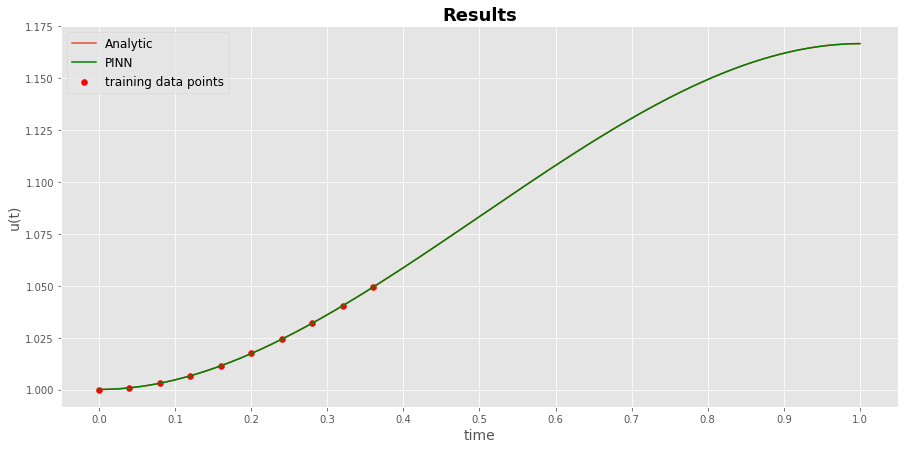

In [13]:
model.eval()
y_pred = model(torch.tensor(x, dtype = torch.float32, device="cuda").reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,)

title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
} 

plt.figure(figsize=(15, 7))
plt.style.use("ggplot")
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.title("Results", title_font)
plt.plot(x, y, label="Analytic")
plt.xlabel("time", fontsize=14)
plt.plot(x, y_pred, label="PINN", c="g")
plt.ylabel("u(t)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="training data points")
plt.legend(fontsize="large")
plt.savefig("1st-Order-ODE.svg")
plt.show()

In [ ]:
import time
PATH = f"LogisticCurveModel_{time.time()}.pt"
torch.save(model.state_dict(), PATH)